In [1]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import json
import re
import nltk
import spacy
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import joblib
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy.optimize import linear_sum_assignment

# 1 Data Preparation & Exploration

In [2]:
BASE_DIR = Path().resolve()
PATH = BASE_DIR / "articles_dataset.csv"
df = pd.read_csv(PATH)
print("Shape:", df.shape)
display(df.head())

Shape: (50, 6)


,id,date,url,title,summary,category
0,1,2024-06-01,https://technews.com/android1,Android Phones with 120Hz Displays,New Android models feature smoother 120Hz refr...,Technology
1,2,2024-06-02,https://technews.com/android2,Android Battery Life Improvements,Manufacturers focus on longer-lasting batteries,Technology
2,3,2024-06-03,https://technews.com/android3,Affordable Android Flagships,New models aim to balance cost and performance,Technology
3,4,2024-06-04,https://technews.com/android4,Camera Innovations in Android,Smartphones introduce advanced AI-driven photo...,Technology
4,5,2024-06-05,https://technews.com/android5,Foldable Android Phones,Flexible displays gain traction in premium seg...,Technology


In [3]:
# Check column dtypes
print("Column dtypes")
print(df.dtypes)

Column dtypes
id           int64
date        object
url         object
title       object
summary     object
category    object
dtype: object


In [4]:
# Convert columns to appropriate dtypes
df["id"] = df["id"].astype(str)
df["date"] = pd.to_datetime(df["date"], errors="coerce")
for col in ["url", "title", "summary", "category"]:
     df[col] = df[col].astype(str)

In [5]:
# check for missing values
print(df.isna().sum())

id          0
date        0
url         0
title       0
summary     0
category    0
dtype: int64


In [6]:
# check for duplicate rows
dup_all = df.duplicated().sum()
print(f"Duplicate rows found: {dup_all}")

Duplicate rows found: 0


In [7]:
# check for duplicate ids
n_total = len(df)
id_unique = df["id"].nunique()
print(f"Total rows: {n_total}, Unique IDs: {id_unique}")

Total rows: 50, Unique IDs: 50


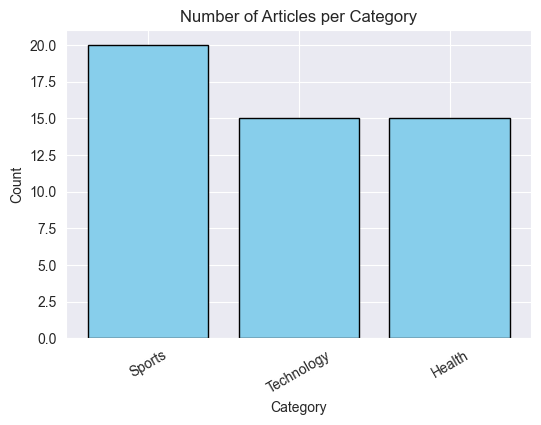

In [8]:
# Summary statistics for numerical columns
counts = df["category"].value_counts()
plt.figure(figsize=(6,4))
plt.bar(counts.index, counts.values, color="skyblue", edgecolor="black")
plt.title("Number of Articles per Category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()

Date range: 2024-06-01 00:00:00 to 2024-07-20 00:00:00


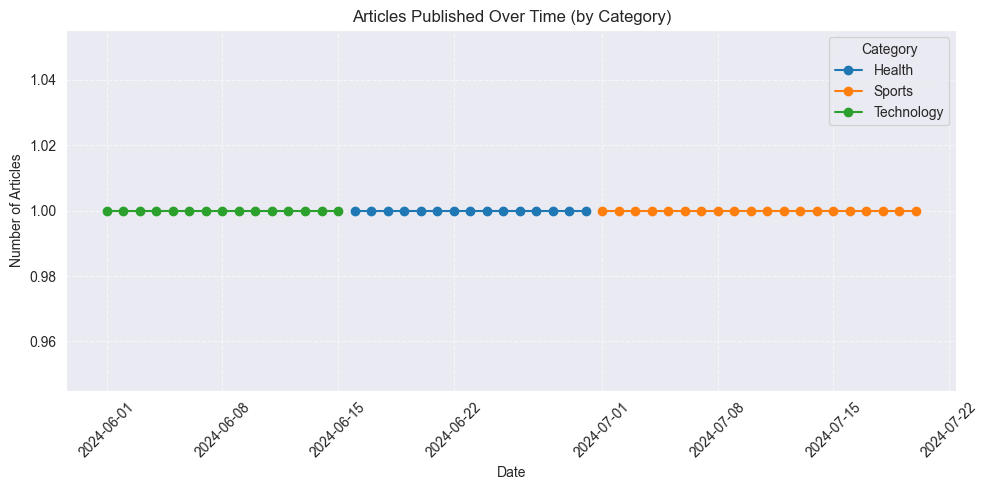

In [9]:
# Summary statistics for date column
print("Date range:", df["date"].min(), "to", df["date"].max())
plt.figure(figsize=(10,5))

for category, subset in df.groupby("category"):
    counts = subset["date"].value_counts().sort_index()
    plt.plot(counts.index, counts.values, marker="o", label=category)

plt.title("Articles Published Over Time (by Category)")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Category")
plt.tight_layout()
plt.show()

In [10]:
# Word count analysis for title and summary
def word_count(s: str) -> int:
    return len(str(s).split()) if isinstance(s, str) else 0

df["title_wc"] = df["title"].apply(word_count)
df["summary_wc"] = df["summary"].apply(word_count)
display(df[["title_wc", "summary_wc"]].describe())

,title_wc,summary_wc
count,50.000000,50.000000
mean,3.360000,5.760000
std,0.662709,1.098422
min,2.000000,4.000000
25%,3.000000,5.000000
50%,3.000000,6.000000
75%,4.000000,6.750000
max,5.000000,8.000000


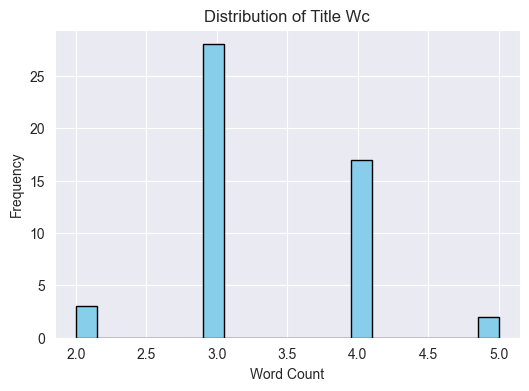

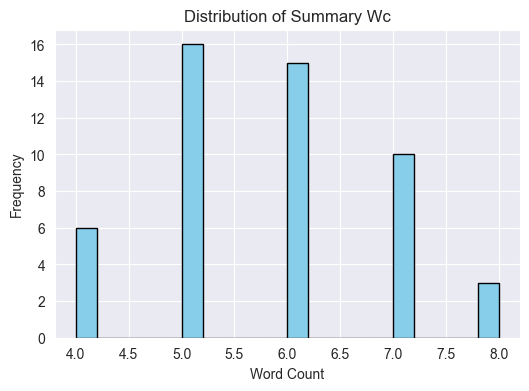

In [11]:
# Visualize word count distributions
for col in ["title_wc", "summary_wc"]:
    plt.figure(figsize=(6,4))
    plt.hist(df[col], bins=20, color="skyblue", edgecolor="black")
    plt.title(f"Distribution of {col.replace('_',' ').title()}")
    plt.xlabel("Word Count")
    plt.ylabel("Frequency")
    plt.show()


<Figure size 800x400 with 0 Axes>

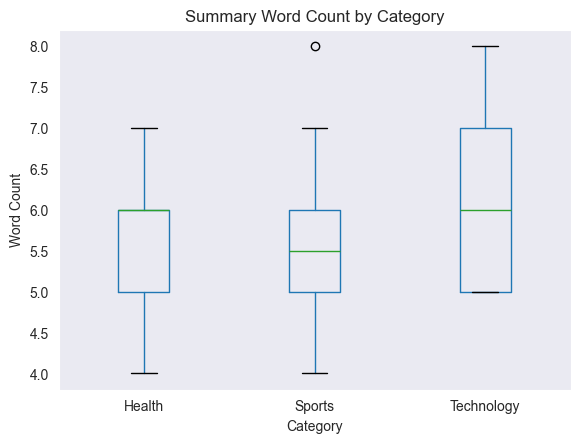

In [12]:
plt.figure(figsize=(8,4))
df.boxplot(column="summary_wc", by="category", grid=False)
plt.title("Summary Word Count by Category")
plt.suptitle("")
plt.xlabel("Category")
plt.ylabel("Word Count")
plt.show()


# 2 Text Preprocessing

In [13]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download("stopwords")
nltk.download("wordnet")

STOPWORDS = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tomis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tomis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
df["text"] = (df["title"].fillna("").astype(str) + " " + df["summary"].fillna("").astype(str)).str.strip()

In [15]:
URL_RE   = re.compile(r"http\S+|www\.\S+")
TOKEN_RE = re.compile(r"[a-z0-9]+")

def clean_text(s: str) -> str:
    s = s.lower()
    s = URL_RE.sub(" ", s)
    tokens = TOKEN_RE.findall(s)
    tokens = [t for t in tokens if t not in STOPWORDS]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

df["text_clean"] = df["text"].apply(clean_text)

In [16]:
df

,id,date,url,title,summary,category,title_wc,summary_wc,text,text_clean
0,1,2024-06-01,https://technews.com/android1,Android Phones with 120Hz Displays,New Android models feature smoother 120Hz refr...,Technology,5,8,Android Phones with 120Hz Displays New Android...,android phone 120hz display new android model ...
1,2,2024-06-02,https://technews.com/android2,Android Battery Life Improvements,Manufacturers focus on longer-lasting batteries,Technology,4,5,Android Battery Life Improvements Manufacturer...,android battery life improvement manufacturer ...
2,3,2024-06-03,https://technews.com/android3,Affordable Android Flagships,New models aim to balance cost and performance,Technology,3,8,Affordable Android Flagships New models aim to...,affordable android flagship new model aim bala...
3,4,2024-06-04,https://technews.com/android4,Camera Innovations in Android,Smartphones introduce advanced AI-driven photo...,Technology,4,5,Camera Innovations in Android Smartphones intr...,camera innovation android smartphones introduc...
4,5,2024-06-05,https://technews.com/android5,Foldable Android Phones,Flexible displays gain traction in premium seg...,Technology,3,7,Foldable Android Phones Flexible displays gain...,foldable android phone flexible display gain t...
5,6,2024-06-06,https://technews.com/wearables1,Smartwatch Market Growth,Fitness tracking drives smartwatch adoption,Technology,3,5,Smartwatch Market Growth Fitness tracking driv...,smartwatch market growth fitness tracking driv...
6,7,2024-06-07,https://technews.com/wearables2,AR Glasses in Retail,Augmented reality glasses enhance shopping exp...,Technology,4,6,AR Glasses in Retail Augmented reality glasses...,ar glass retail augmented reality glass enhanc...
7,8,2024-06-08,https://technews.com/wearables3,Fitness Trackers Popular Among Youth,Young consumers adopt trackers for daily health,Technology,5,7,Fitness Trackers Popular Among Youth Young con...,fitness tracker popular among youth young cons...
8,9,2024-06-09,https://technews.com/wearables4,Smartwatches for Athletes,New models track running and swimming metrics,Technology,3,7,Smartwatches for Athletes New models track run...,smartwatches athlete new model track running s...
9,10,2024-06-10,https://technews.com/wearables5,AR Glasses for Education,Classrooms experiment with immersive lessons,Technology,4,5,AR Glasses for Education Classrooms experiment...,ar glass education classroom experiment immers...


### 2.2 Extract basic entities (e.g., named entities for people, organizations, places).

In [17]:
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "spacy"])
subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])

0

In [18]:
nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","attribute_ruler","lemmatizer"])

entities_col = []
for doc in nlp.pipe(df["text"].tolist(), batch_size=64):
    bucket = {"PERSON": [], "ORG": [], "GPE": []}
    for ent in doc.ents:
        if ent.label_ in bucket:
            bucket[ent.label_].append(ent.text)
    entities_col.append({k: sorted(set(v)) for k, v in bucket.items()})

df["entities"] = entities_col
df[["id", "entities"]].head(5)

,id,entities
0,1,"{'PERSON': [], 'ORG': ['Android Phones', 'Disp..."
1,2,"{'PERSON': [], 'ORG': ['Android Battery Life I..."
2,3,"{'PERSON': [], 'ORG': [], 'GPE': []}"
3,4,"{'PERSON': [], 'ORG': [], 'GPE': ['AI']}"
4,5,"{'PERSON': [], 'ORG': [], 'GPE': []}"


### 2.3 Compute text embeddings (e.g., using sentence-transformers or OpenAI embeddings).

In [19]:
texts = df["text_clean"].astype(str).tolist()

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model_name = "all-MiniLM-L6-v2"
encoder = SentenceTransformer(model_name, device=device)

X = encoder.encode(
    texts,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True
)

print("Encoder:", f"sentence-transformers:{model_name}")
print("Embedding shape:", X.shape)

Using device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoder: sentence-transformers:all-MiniLM-L6-v2
Embedding shape: (50, 384)


# 3 Clustering & Ranking

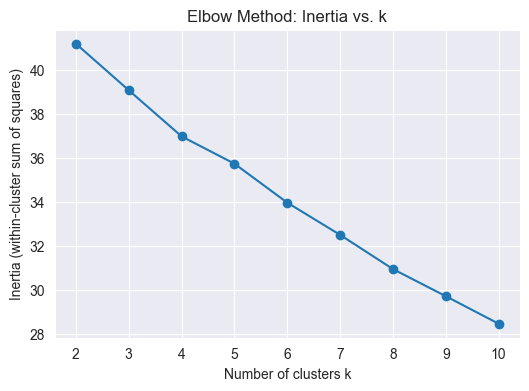

In [20]:
Ks = range(2, 11)
inertias = []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(Ks, inertias, marker="o")
plt.title("Elbow Method: Inertia vs. k")
plt.xlabel("Number of clusters k")
plt.ylabel("Inertia (within-cluster sum of squares)")
plt.show()

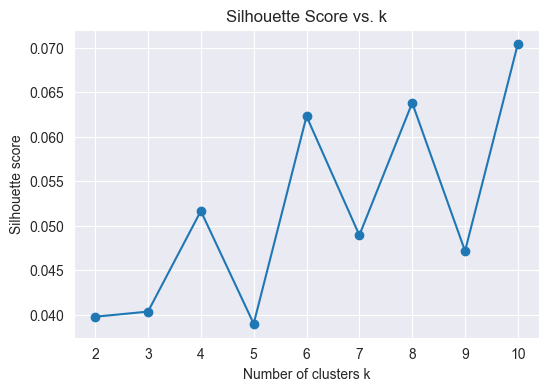

In [21]:
scores = []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X)
    labels = km.labels_
    score = silhouette_score(X, labels)
    scores.append(score)

plt.figure(figsize=(6,4))
plt.plot(Ks, scores, marker="o")
plt.title("Silhouette Score vs. k")
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette score")
plt.show()

In [22]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df["cluster_kmeans"] = kmeans.fit_predict(X)
print("Cluster distribution:")
print(df["cluster_kmeans"].value_counts())


ARTIFACT_DIR = Path("artifacts")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

joblib.dump(kmeans, ARTIFACT_DIR / "kmeans_model.joblib")
print("Saved KMeans model to:", ARTIFACT_DIR / "kmeans_model.joblib")

Cluster distribution:
cluster_kmeans
2    25
0    17
1     8
Name: count, dtype: int64
Saved KMeans model to: artifacts\kmeans_model.joblib


In [23]:
ARTIFACT_DIR = Path("artifacts")
cluster_labels = {
    0: "Technology",
    1: "Health",
    2: "Sports"
}
with open(ARTIFACT_DIR / "cluster_labels.json", "w") as f:
    json.dump(cluster_labels, f)


In [24]:
hier = AgglomerativeClustering(n_clusters=3, metric="euclidean", linkage="ward")
df["cluster_hier"] = hier.fit_predict(X.toarray() if hasattr(X, "toarray") else X)
print("Cluster distribution:")
print(df["cluster_hier"].value_counts())

Cluster distribution:
cluster_hier
0    25
1    14
2    11
Name: count, dtype: int64


In [25]:
df

,id,date,url,title,summary,category,title_wc,summary_wc,text,text_clean,entities,cluster_kmeans,cluster_hier
0,1,2024-06-01,https://technews.com/android1,Android Phones with 120Hz Displays,New Android models feature smoother 120Hz refr...,Technology,5,8,Android Phones with 120Hz Displays New Android...,android phone 120hz display new android model ...,"{'PERSON': [], 'ORG': ['Android Phones', 'Disp...",0,0
1,2,2024-06-02,https://technews.com/android2,Android Battery Life Improvements,Manufacturers focus on longer-lasting batteries,Technology,4,5,Android Battery Life Improvements Manufacturer...,android battery life improvement manufacturer ...,"{'PERSON': [], 'ORG': ['Android Battery Life I...",0,0
2,3,2024-06-03,https://technews.com/android3,Affordable Android Flagships,New models aim to balance cost and performance,Technology,3,8,Affordable Android Flagships New models aim to...,affordable android flagship new model aim bala...,"{'PERSON': [], 'ORG': [], 'GPE': []}",0,0
3,4,2024-06-04,https://technews.com/android4,Camera Innovations in Android,Smartphones introduce advanced AI-driven photo...,Technology,4,5,Camera Innovations in Android Smartphones intr...,camera innovation android smartphones introduc...,"{'PERSON': [], 'ORG': [], 'GPE': ['AI']}",0,0
4,5,2024-06-05,https://technews.com/android5,Foldable Android Phones,Flexible displays gain traction in premium seg...,Technology,3,7,Foldable Android Phones Flexible displays gain...,foldable android phone flexible display gain t...,"{'PERSON': [], 'ORG': [], 'GPE': []}",0,0
5,6,2024-06-06,https://technews.com/wearables1,Smartwatch Market Growth,Fitness tracking drives smartwatch adoption,Technology,3,5,Smartwatch Market Growth Fitness tracking driv...,smartwatch market growth fitness tracking driv...,"{'PERSON': [], 'ORG': ['Smartwatch Market Grow...",0,0
6,7,2024-06-07,https://technews.com/wearables2,AR Glasses in Retail,Augmented reality glasses enhance shopping exp...,Technology,4,6,AR Glasses in Retail Augmented reality glasses...,ar glass retail augmented reality glass enhanc...,"{'PERSON': [], 'ORG': ['AR Glasses', 'Retail A...",0,0
7,8,2024-06-08,https://technews.com/wearables3,Fitness Trackers Popular Among Youth,Young consumers adopt trackers for daily health,Technology,5,7,Fitness Trackers Popular Among Youth Young con...,fitness tracker popular among youth young cons...,"{'PERSON': [], 'ORG': [], 'GPE': []}",0,0
8,9,2024-06-09,https://technews.com/wearables4,Smartwatches for Athletes,New models track running and swimming metrics,Technology,3,7,Smartwatches for Athletes New models track run...,smartwatches athlete new model track running s...,"{'PERSON': [], 'ORG': [], 'GPE': ['Athletes']}",0,2
9,10,2024-06-10,https://technews.com/wearables5,AR Glasses for Education,Classrooms experiment with immersive lessons,Technology,4,5,AR Glasses for Education Classrooms experiment...,ar glass education classroom experiment immers...,"{'PERSON': [], 'ORG': ['AR Glasses'], 'GPE': []}",0,0


In [26]:
# TF-IDF on cleaned text
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(df["text_clean"])

# NMF topic model
nmf = NMF(n_components=6, random_state=42)
W = nmf.fit_transform(X_tfidf)   # doc-topic matrix
H = nmf.components_              # topic-word matrix

# Assign each doc to its strongest topic
df["cluster_nmf"] = W.argmax(axis=1)

# Show top words per topic
feature_names = tfidf.get_feature_names_out()
for i, topic in enumerate(H):
    top_words = [feature_names[j] for j in topic.argsort()[-10:][::-1]]
    print(f"Topic {i}: {', '.join(top_words)}")


Topic 0: new, smartwatches, track, new model, swimming, model, runner, athlete, running, model track
Topic 1: diet, benefit, linked, health, heart, mediterranean, heart health, improved, improved heart, linked improved
Topic 2: shoe, lightweight, lightweight shoe, technology, tennis, improve, shoe improve, technology lightweight, marathon result, running shoe
Topic 3: apps, yoga, club, gain popularity, popularity, user, gain, sleep, fitness, tracking
Topic 4: glass, ar, ar glass, experiment immersive, glass education, immersive, immersive lesson, classroom, lesson, education
Topic 5: android, 120hz, android phone, phone, display, foldable, flexible display, display gain, foldable android, gain traction


C:\Users\tomis\Documents\Recommend\.venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


#### LLM clustering

In [40]:
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

docs = df["text"].tolist()

prompt = "Here are 50 article texts:\n\n"
for i, doc in enumerate(docs):
    prompt += f"Document {i}: {doc}\n"

prompt += """
Group these documents into 3 coherent categories.
For each category:
- Provide a short label (e.g., 'Health', 'Technology', 'Sports')
- List the document IDs (numbers above).
Return the result as JSON with format:
{
  "Cluster 0": {"label": "...", "docs": [0,2,5,...]},
  "Cluster 1": {"label": "...", "docs": [...]},
  "Cluster 2": {"label": "...", "docs": [...]}
}
"""

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": prompt}],
    temperature=0
)

result = response.choices[0].message.content
print(result)

```json
{
  "Cluster 0": {
    "label": "Technology",
    "docs": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  },
  "Cluster 1": {
    "label": "Health & Fitness",
    "docs": [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
  },
  "Cluster 2": {
    "label": "Sports",
    "docs": [30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
  }
}
```


In [28]:
clean_result = re.sub(r"```(?:json)?", "", result).strip()
clusters = json.loads(clean_result)

# Build a mapping: doc index → cluster label
mapping = {}
for cluster_id, data in clusters.items():
    label = data["label"]
    for doc_idx in data["docs"]:
        mapping[doc_idx] = label

df["cluster_llm"] = df.index.map(mapping)
df[["id", "title", "cluster_llm"]].head()


,id,title,cluster_llm
0,1,Android Phones with 120Hz Displays,Technology
1,2,Android Battery Life Improvements,Technology
2,3,Affordable Android Flagships,Technology
3,4,Camera Innovations in Android,Technology
4,5,Foldable Android Phones,Technology


In [29]:
ARTIFACT_DIR = Path("artifacts")
examples_by_cluster = (
    df.groupby("cluster_llm")["text"].apply(list).to_dict()
)

with open(ARTIFACT_DIR / "llm_clusters.json", "w") as f:
    json.dump(examples_by_cluster, f, indent=2)

In [30]:
unassigned = df[df["cluster_llm"].isna()]
print("Unassigned documents:")
print(unassigned[["id", "title"]])
df["cluster_llm"].fillna("Unassigned", inplace=True)


Unassigned documents:
    id                         title
39  40  Injury Prevention in Running


C:\Users\tomis\AppData\Local\Temp\ipykernel_34116\3797609306.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["cluster_llm"].fillna("Unassigned", inplace=True)


In [31]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

def evaluate_external(y_true, y_pred, name):
    ari = adjusted_rand_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    print(f"{name}: ARI={ari:.3f}, NMI={nmi:.3f}")

evaluate_external(df["category"], df["cluster_kmeans"], "KMeans")
evaluate_external(df["category"], df["cluster_hier"], "Agglomerative")
evaluate_external(df["category"], df["cluster_llm"], "LLM-based")

KMeans: ARI=0.255, NMI=0.315
Agglomerative: ARI=0.405, NMI=0.512
LLM-based: ARI=0.964, NMI=0.965


## Ranking

In [32]:
centroids = kmeans.cluster_centers_
sims = []

for i, row in df.iterrows():
    vec = X[i].reshape(1, -1)
    cluster_id = row["cluster_kmeans"]
    centroid = centroids[cluster_id].reshape(1, -1)
    sim = cosine_similarity(vec, centroid)[0][0]
    sims.append(sim)

df["cluster_score"] = sims
ranked = df.groupby("cluster_kmeans").apply(
    lambda g: g.sort_values("cluster_score", ascending=False).head(3)
)
print(ranked[["id", "title", "cluster_kmeans", "cluster_score"]])


                   id                            title  cluster_kmeans  \
cluster_kmeans                                                           
0              38  39         Smartwatches for Runners               0   
               8    9        Smartwatches for Athletes               0   
               5    6         Smartwatch Market Growth               0   
1              10  11       Data Privacy Concerns Rise               1   
               11  12         Ransomware Attacks Surge               1   
               28  29            Pandemic Preparedness               1   
2              49  50           Swimming World Records               2   
               16  17  Protein-Rich Foods for Athletes               2   
               30  31            Wimbledon 2024 Begins               2   

                   cluster_score  
cluster_kmeans                    
0              38       0.694236  
               8        0.690808  
               5        0.656264  
1         

C:\Users\tomis\AppData\Local\Temp\ipykernel_34116\2899168228.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ranked = df.groupby("cluster_kmeans").apply(


In [33]:
# Problem: Agglomerative clustering doesn’t compute centroids.
# Solution: Define a “pseudo-centroid” = mean embedding of all docs in the cluster, then rank articles by cosine similarity to that mean.
def rank_cluster_articles(X, labels, df, top_n=3):
    X = np.array(X)
    results = []
    for cluster_id in np.unique(labels):
        mask = (labels == cluster_id)
        cluster_vecs = X[mask]
        cluster_center = cluster_vecs.mean(axis=0).reshape(1, -1)
        sims = cosine_similarity(cluster_vecs, cluster_center).flatten()
        
        cluster_df = df[mask].copy()
        cluster_df["cluster_score"] = sims
        top_docs = cluster_df.sort_values("cluster_score", ascending=False).head(top_n)
        results.append(top_docs)
    
    return pd.concat(results)

ranked_hier = rank_cluster_articles(X, df["cluster_hier"].values, df, top_n=3)
print(ranked_hier[["cluster_hier", "id", "title", "cluster_score"]])

    cluster_hier  id                                 title  cluster_score
5              0   6              Smartwatch Market Growth       0.578162
7              0   8  Fitness Trackers Popular Among Youth       0.578115
21             0  22             Yoga Apps Gain Popularity       0.533853
30             1  31                 Wimbledon 2024 Begins       0.630539
33             1  34               Tennis Shoes Comparison       0.603728
46             1  47                 Golf Major Tournament       0.595973
8              2   9             Smartwatches for Athletes       0.737789
38             2  39              Smartwatches for Runners       0.733020
20             2  21              Fitness Apps for Runners       0.680292


In [34]:
# You can do the same trick: compute the mean embedding per LLM cluster, then rank by cosine similarity.
ranked_llm = rank_cluster_articles(X, df["cluster_llm"].astype("category").cat.codes.values, df, top_n=3)
print(ranked_llm[["cluster_llm", "id", "title", "cluster_score"]])

         cluster_llm  id                                 title  cluster_score
15  Health & Fitness  16         Low-Carb Diets Remain Popular       0.581686
19  Health & Fitness  20           Mediterranean Diet Benefits       0.575478
22  Health & Fitness  23                   Home Workout Trends       0.573519
33            Sports  34               Tennis Shoes Comparison       0.644229
30            Sports  31                 Wimbledon 2024 Begins       0.602906
49            Sports  50                Swimming World Records       0.588548
5         Technology   6              Smartwatch Market Growth       0.652940
2         Technology   3          Affordable Android Flagships       0.562413
7         Technology   8  Fitness Trackers Popular Among Youth       0.546319
39        Unassigned  40          Injury Prevention in Running       1.000000


In [35]:
def cluster_cohesion_separation(X, labels):
    X = np.array(X)
    results = {}
    unique_clusters = np.unique(labels)
    sim_matrix = cosine_similarity(X)
    
    for c in unique_clusters:
        idx = np.where(labels == c)[0]
        if len(idx) < 2:
            continue
        # Cohesion: average similarity inside cluster
        intra_sims = sim_matrix[np.ix_(idx, idx)]
        cohesion = (np.sum(intra_sims) - len(idx)) / (len(idx)*(len(idx)-1))
        
        # Separation: avg distance to other clusters
        other_idx = np.where(labels != c)[0]
        inter_sims = sim_matrix[np.ix_(idx, other_idx)]
        separation = np.mean(inter_sims)
        
        results[c] = {"cohesion": cohesion, "separation": separation}
    return results

def pretty_metrics(metrics_dict, name="Clustering"):
    df_metrics = pd.DataFrame(metrics_dict).T  # transpose so clusters are rows
    df_metrics.index.name = "Cluster"
    df_metrics.reset_index(inplace=True)
    df_metrics["Clustering"] = name
    return df_metrics.round(3)  # round to 3 decimals

metrics = cluster_cohesion_separation(X, df["cluster_kmeans"].values)
metrics2 = cluster_cohesion_separation(X, df["cluster_hier"].values)
metrics3 = cluster_cohesion_separation(X, df["cluster_llm"].values)

print(pretty_metrics(metrics, "KMeans"))
print(pretty_metrics(metrics2, "Hierarchical"))
print(pretty_metrics(metrics3, "LLM"))

   Cluster  cohesion  separation Clustering
0        0     0.235       0.089     KMeans
1        1     0.147       0.036     KMeans
2        2     0.131       0.076     KMeans
   Cluster  cohesion  separation    Clustering
0        0     0.109       0.068  Hierarchical
1        1     0.185       0.066  Hierarchical
2        2     0.330       0.114  Hierarchical
            Cluster  cohesion  separation Clustering
0  Health & Fitness     0.148       0.084        LLM
1            Sports     0.177       0.076        LLM
2        Technology     0.144       0.082        LLM


In [36]:
def map_clusters_to_categories(y_true, y_pred):
    mapping = {}
    for cluster in set(y_pred):
        # find majority category inside this cluster
        mask = (y_pred == cluster)
        majority = df.loc[mask, "category"].mode()[0]
        mapping[cluster] = majority
    return mapping

# Example for KMeans
mapping_kmeans = map_clusters_to_categories(df["category"], df["cluster_kmeans"])
print("Cluster → Category mapping (KMeans):", mapping_kmeans)

mapping_hier = map_clusters_to_categories(df["category"], df["cluster_hier"])
print("Cluster → Category mapping (Hierarchical):", mapping_hier)

Cluster → Category mapping (KMeans): {0: 'Technology', 1: 'Technology', 2: 'Sports'}
Cluster → Category mapping (Hierarchical): {0: 'Technology', 1: 'Sports', 2: 'Sports'}


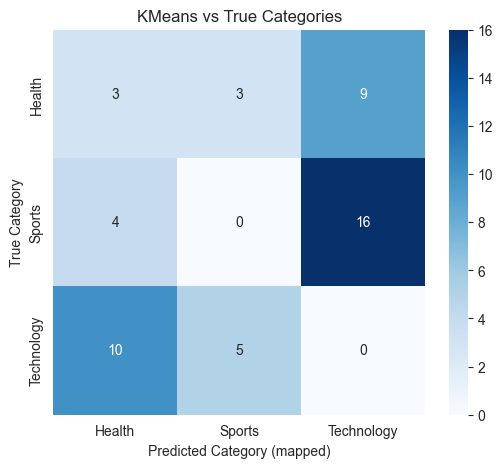

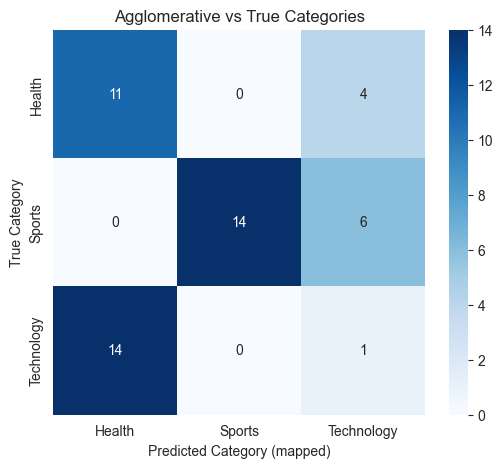

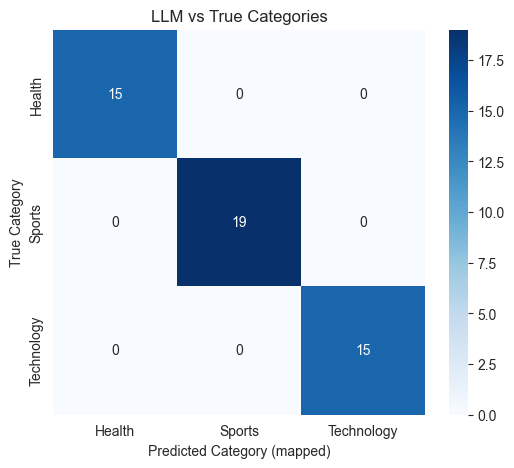

In [37]:
def best_cluster_mapping(y_true, y_pred):
    """Map cluster labels to true labels using Hungarian algorithm."""
    categories = list(sorted(set(y_true)))
    clusters = list(sorted(set(y_pred)))
    
    # Build confusion matrix between categories and clusters
    cm = confusion_matrix(y_true, y_pred, labels=categories)
    
    # Hungarian algorithm: find best cluster → category assignment
    row_ind, col_ind = linear_sum_assignment(-cm)  # maximize accuracy
    mapping = {clusters[j]: categories[i] for i, j in zip(row_ind, col_ind)}
    return mapping

def plot_confusion_mapped(y_true, y_pred, title):
    # Map cluster IDs to category labels
    mapping = best_cluster_mapping(y_true, y_pred)
    y_pred_mapped = [mapping.get(c, "Unmapped") for c in y_pred]
    
    cm = confusion_matrix(y_true, y_pred_mapped, labels=sorted(set(y_true)))
    categories = sorted(set(y_true))

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted Category (mapped)")
    plt.ylabel("True Category")
    plt.title(title)
    plt.show()

plot_confusion_mapped(df["category"], df["cluster_kmeans"], "KMeans vs True Categories")
plot_confusion_mapped(df["category"], df["cluster_hier"], "Agglomerative vs True Categories")
plot_confusion_mapped(df["category"], df["cluster_llm"], "LLM vs True Categories")


# 5 LLM Integration (Optional, Simplified) - some free option if available

In [38]:
def summarize_cluster(titles, cluster_name):
    prompt = f"""
Here are some article titles from the cluster '{cluster_name}':
- {chr(10).join(titles)}

Summarize the overall theme of this cluster in 2-3 sentences.
"""
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role":"user", "content":prompt}]
    )
    return response.choices[0].message.content.strip()

# Summarize LLM clusters
summaries = {}
for label in df["cluster_llm"].unique():
    titles = df[df["cluster_llm"]==label]["summary"].head(7).tolist()
    summaries[label] = summarize_cluster(titles, label)

for label, text in summaries.items():
    print(f"{label}: {text}\n")


Technology: The articles in this technology cluster highlight the latest advancements in consumer electronics, particularly smartphones and smartwatches. Key trends include improvements in display technology with higher refresh rates, extended battery life, and innovative features like AI-driven photography and augmented reality. The focus is on enhancing user experience while balancing cost and performance, indicating a shift towards more versatile and functional devices.

Health & Fitness: The cluster of articles focuses on contemporary trends and recommendations in health and fitness, highlighting the significance of diet and nutrition in weight management and heart health. It emphasizes the growing popularity of plant-based diets and the push for reduced sugar intake by governments, while also showcasing the rise of digital tools and platforms that offer personalized training and wellness solutions. Overall, the theme reflects a holistic approach to maintaining health through infor

In [39]:
prompt = f"""
Here are all article titles with summaries:
{chr(10).join(f"- {d}" for d in df['text'])}

Based on the themes in these documents:
1. Suggest how many coherent clusters (categories) exist.
2. Give each cluster a short name.
3. List which articles (by index order) belong to each cluster.
Return the result as a JSON object with format:
{{
  "num_clusters": <number>,
  "clusters": {{
      "Cluster 0": {{"label": "...", "docs": [0,1,2]}},
      "Cluster 1": {{"label": "...", "docs": [3,4,5]}},
      ...
  }}
}}
Do it for all entries from 1 to 50!
"""

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role":"user","content":prompt}]
)

result = response.choices[0].message.content
print(result)


```json
{
  "num_clusters": 6,
  "clusters": {
    "Cluster 0": {
      "label": "Android Devices",
      "docs": [0, 1, 2, 3, 4]
    },
    "Cluster 1": {
      "label": "Wearable Technology",
      "docs": [5, 6, 7, 8, 9]
    },
    "Cluster 2": {
      "label": "Health and Nutrition",
      "docs": [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
    },
    "Cluster 3": {
      "label": "Technology in Education and Security",
      "docs": [20, 21, 22, 23, 24, 25, 26]
    },
    "Cluster 4": {
      "label": "Sports Updates",
      "docs": [27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
    },
    "Cluster 5": {
      "label": "Major Events and Competitions",
      "docs": [37, 38, 39, 40, 41, 42, 43]
    }
  }
}
```
